# ***1. Importing Libraries***

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

**NOTES :-**  
The code starts by importing essential libraries for data manipulation, visualization, and model building.

* pandas and numpy are used for handling data in tabular form and numerical operations.
* tensorflow provides deep learning functionalities, with specific modules for layers, models, and preprocessing.
* os is used for handling file system operations.
* matplotlib and seaborn are used for visualizing data, model performance, and confusion matrices.
* The code also imports InceptionV3, a pre-trained model, and ImageDataGenerator for augmenting image data to improve model robustness. These libraries provide all the necessary tools to perform transfer learning and evaluate the model’s performance.

# ***2. LOAD DATA***

In [ ]:
train_path = "/content/whatsapp_images/train"
test_path = "/content/whatsapp_images/test"

# ***3. DATA AUGMENTATION***

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    rotation_range=20,          # Random rotation
    width_shift_range=0.2,      # Random horizontal shift
    height_shift_range=0.2,     # Random vertical shift
    shear_range=0.2,            # Shearing transformations
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Random horizontal flipping
    fill_mode='nearest'         # Filling for empty pixels
    )
train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size=BATCH_SIZE,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


**NOTES :-**  
Data augmentation is a technique used to artificially increase the diversity of the training dataset. We can introduce data augmentation techniques to enrich the dataset, which helps mitigate overfitting and enhances robustness.

* The ImageDataGenerator class preprocesses the images using the InceptionV3 model’s input requirements (preprocess_input).
*Images are resized to 224x224 pixels, which matches the input size expected by the model.
* Augmentations like rescaling, rotation, and flipping (if used) improve model generalization by preventing overfitting on the training data. In this case, augmentation enhances the training set, while test images are only preprocessed without augmentation to retain their original distribution.
* Rotation, shifts, shear, and zoom: Introducing slight variations in orientation and size will help the model learn invariant features.
* Horizontal flip: Since certain lung conditions are mirrored on either side, flipping can help with class imbalance.

# ***4. MODEL BUILDING***

In [ ]:
# Load InceptionV3 with pre-trained weights
inc_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
inc_model.trainable = False  # Freeze the base model

In [ ]:
model = Sequential([
    inc_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_864              │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_865              │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_866              │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

**NOTES:-**  
Transfer learning is implemented using the InceptionV3 model, which is pre-trained on the ImageNet dataset.

* The include_top=False argument removes the model’s fully connected layers, leaving only the feature extraction layers.
* The model's weights are frozen (trainable=False) to retain the learned features, making the training more efficient by focusing only on the added dense layers.
* The code then constructs a Sequential model, adding layers like GlobalAveragePooling2D (to reduce dimensionality) and multiple fully connected layers with BatchNormalization and Dropout (for regularization).  
* The final layer uses softmax activation to classify the images into multiple classes, which makes this setup effective for multi-class classification problems.

# ***5(a). MODEL TRAINING***

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.4218 - loss: 1.5319 - val_accuracy: 0.3746 - val_loss: 3.5464
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.6443 - loss: 0.8074 - val_accuracy: 0.5619 - val_loss: 1.1916
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.7522 - loss: 0.6459 - val_accuracy: 0.4127 - val_loss: 1.6831
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.8312 - loss: 0.4478 - val_accuracy: 0.5905 - val_loss: 1.2837
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.8747 - loss: 0.3749 - val_accuracy: 0.4190 - val_loss: 2.0304
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.8824 - loss: 0.3339 - val_accuracy: 0.5206 - val_loss: 1.3905
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.8791 - loss: 0.3291 - val_accuracy: 0.6222 - val_loss: 1.1104
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.8955 - loss: 0.2928 - val_accuracy: 0.6476 - v

**NOTES:-**  
The model is compiled using the Adam optimizer and categorical_crossentropy loss, which is appropriate for multi-class classification problems.

* Training is conducted over 50 epochs using the fit function, with both the training and validation data passed to monitor the model's performance.
* As the model trains, it adjusts its weights based on the training data while checking validation accuracy to prevent overfitting.
* Assigning higher weights to underrepresented classes during training encourages the model to focus more on those classes, thereby improving performance on them.

# ***5(b) MODEL TRAINING PLOT***

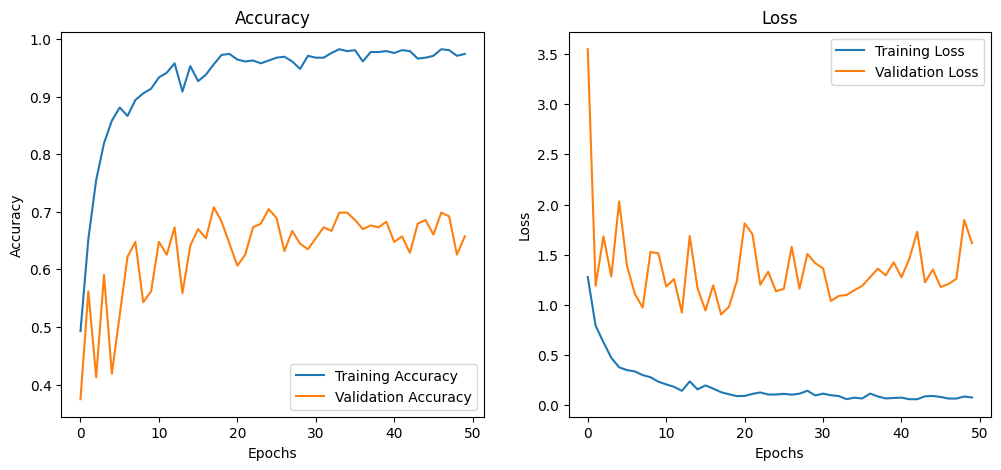

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**NOTES:-**
* During the first few epochs, the accuracy improves significantly, but as seen in the later epochs, overfitting starts to occur (higher validation loss).
* This is a common challenge, suggesting the model may benefit from techniques like early stopping or additional regularization. Training a transfer learning model like this allows for leveraging pre-trained features, improving accuracy even with a relatively small dataset.